In [320]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [321]:
import os
import glob

from pandas.api.types import CategoricalDtype

HOME = "/home/kwatchar3/spauq-home/spauq/expt/degradation/timit/results-2s/delaypan"

results = glob.glob(os.path.join(HOME, "*.csv"))

dfs = []

for r in results:
    df = pd.read_csv(r).rename(columns={'Unnamed: 0': 'filename', 'Unnamed: 1': 'delay', 'Unnamed: 2': 'est_pan'})
    # df = pd.read_csv(r).rename(columns={'Unnamed: 0': 'filename', 'Unnamed: 1': 'est_pan'})
    dfs.append(df)

# df['ref_pan'] = df['ref_pan'].apply(lambda x: np.round(x*10)/10)
df['est_pan'] = df['est_pan'].apply(lambda x: np.round(x*10)/10)
# df['pan_err'] = df['est_pan'] - df['ref_pan']

df0 = df.copy()

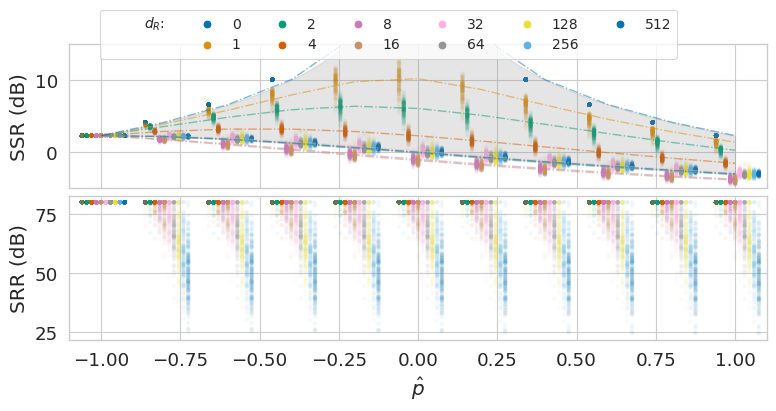

In [332]:
df = df0.copy()

p = np.concatenate([np.linspace(-1, 1, 100)])

def theoretical_ssr(p, upper, p0=0):
    if upper:
        t = np.sin(0.25 * np.pi * (p+1)) * np.sin(0.25 * np.pi * (p0+1)) * (1 - -1)
    else:
        t = np.sin(0.25 * np.pi * (p+1)) * np.sin(0.25 * np.pi * (p0+1)) * 0
    ssr = -10*np.log10(2 - 2 * np.cos(0.25 * np.pi * (p-p0)) + t)
    
    return ssr


sns.set("paper", "whitegrid", "colorblind", font_scale=1.5)
f, axs = plt.subplots(2, 1, figsize=(8,4))


ax = axs[0]
palette = sns.color_palette("colorblind", n_colors=len(df.delay.unique()))

dmax = 32

dfm = df.groupby(['delay', 'est_pan']).median(numeric_only=True).reset_index()


df['est_pan'] = df[['delay', 'est_pan']].apply(lambda r: r.est_pan + 0.15 * ((np.log2(r.delay) if r.delay > 0 else 0) -4)/10, axis=1)
# sns.scatterplot(df, y='SSR', x='est_pan', hue='delay', palette="colorblind", ax=ax, alpha=0.005, edgecolor="none")
sns.scatterplot(df, y='SSR', x='est_pan', hue='delay', palette="colorblind", ax=ax, edgecolor="none", alpha=0.05, s=10)
h, l = ax.get_legend_handles_labels()


kwargs = dict(ax=ax, linestyle='-.', linewidth=1, zorder=5, alpha=0.5)
sns.lineplot(dfm[~((dfm.delay==0))], y='SSR', x='est_pan', hue='delay', palette=palette[1:], **kwargs)
sns.lineplot(dfm[((dfm.delay==0) & (dfm.est_pan < 0))], y='SSR', x='est_pan', hue='delay', palette=[palette[0]], **kwargs)
sns.lineplot(dfm[((dfm.delay==0) & (dfm.est_pan > 0))], y='SSR', x='est_pan', hue='delay', palette=[palette[0]], **kwargs)

ssr0 = theoretical_ssr(p, 0)
ssr1 = theoretical_ssr(p, 1)
ax.fill_between(p, ssr1, ssr0, zorder=1, edgecolor="none", color="gray", alpha=0.2)
xlim = [-1.1, 1.1]
ax.set(ylim=[-5, 15], ylabel='SSR (dB)', xlim=xlim, xticklabels=[], xlabel=None)

ax.legend().remove()
h = [plt.plot([], marker="", ls="")[0], plt.plot([], marker="", ls="")[0]] + h
l = ['$d_R$:', ""] + l
f.legend(h, l, loc='upper center', fontsize=10, ncols=7, bbox_to_anchor=(0.5, 1.05))

ax = axs[1]
sns.scatterplot(df, y='SRR', x='est_pan', hue='delay', palette="colorblind", ax=ax, edgecolor="none", alpha=0.05, s=10, legend=False)
ax.set(ylabel='SRR (dB)', xlabel='$\hat{p}$', xlim=xlim)

plt.tight_layout()
f.align_ylabels(axs)
f.subplots_adjust(wspace=0, hspace=0.05)

plt.savefig("figs/delaypan.pdf", bbox_inches='tight')

plt.show()

In [323]:
import json
df = df0.copy()
df['scalex'] = df.apply(lambda r: str(
    np.round(
        np.sqrt(np.sum(np.square(json.loads(r.scale)), axis=1)) - ideal_gain(r.est_pan), 
        3)),
                        axis=1
                       )

In [324]:
def ideal_gain(p):
    return np.array([np.cos(0.25*np.pi*(p+1)), np.sin(0.25*np.pi*(p+1))])

In [325]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df.groupby(['delay', 'est_pan']).value_counts(['scalex']))

delay  est_pan  scalex         
0      -1.0     [-0.  0.]          144
                [0. 0.]             24
       -0.8     [-0. -0.]          125
                [-0.  0.]           16
                [0. 0.]             14
                [ 0. -0.]           13
       -0.6     [-0. -0.]          114
                [-0.  0.]           32
                [0. 0.]             14
                [ 0. -0.]            8
       -0.4     [-0. -0.]           73
                [-0.  0.]           72
                [0. 0.]             20
                [ 0. -0.]            3
       -0.2     [-0. -0.]          118
                [-0.  0.]           25
                [0. 0.]             14
                [ 0. -0.]           11
        0.0     [-0. -0.]          126
                [ 0. -0.]           18
                [-0.  0.]           16
                [0. 0.]              8
        0.2     [-0. -0.]           93
                [-0.  0.]           68
                [0. 0.]         

In [326]:
sns.scatterplot(df, x='delay', y='r2rshift', ax=ax, alpha=0.01)

ValueError: Could not interpret value `r2rshift` for parameter `y`